Coordinates of detected peaks: [(np.float64(23.0691464), np.float64(1.9214624507968384e-09)), (np.float64(69.2295952), np.float64(1.9398060994047606e-09)), (np.float64(90.9530816), np.float64(1.3848571712818964e-09)), (np.float64(115.3914641), np.float64(1.1508671337677089e-09)), (np.float64(137.1144024), np.float64(1.8978240450219857e-09)), (np.float64(183.2745388), np.float64(1.6723171216023165e-09))]
Coordinates saved to /Users/nikidis/Documents/GitHub/phonons/frequency_study/wp8_4thz/4thz_450.txt
Plot saved as /Users/nikidis/Documents/GitHub/phonons/frequency_study/wp8_4thz/4thz_450.tif


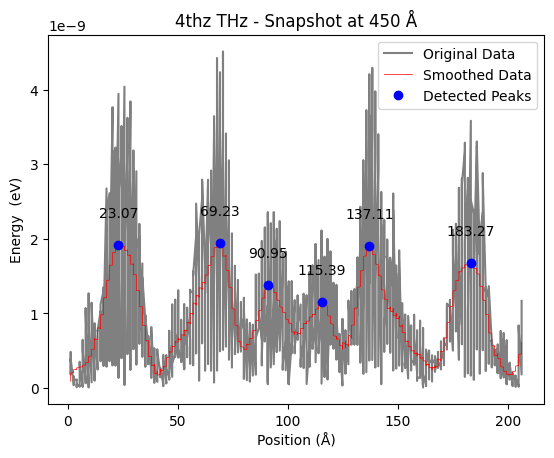

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

# Specific file path
file_path = "/Users/nikidis/Documents/GitHub/phonons/frequency_study/wp8_4thz/450.csv"

# Function to extract THz and Å values from the file path
def extract_values_from_path(path):
    parts = path.split('/')
    thz_value = parts[-2].split('_')[1]  # Extract THz value from the second last part
    angstrom_value = parts[-1].split('.')[0]  # Extract Å value from the file name
    return thz_value, angstrom_value

# Extract THz and Å values
thz_value, angstrom_value = extract_values_from_path(file_path)

# Read the CSV file
colnames = ['position', 'energy']
data = pd.read_csv(file_path, sep=" ", names=colnames, index_col=False)
data = data.sort_values(by='position')

# Extract data
x = data['position'].values
y = data['energy'].values

# Create line plot from scatter plot data
plt.plot(x, y, label='Original Data', color='gray', alpha=1, linewidth=1.5)

# Apply Savitzky-Golay filter to smooth the data
window_length = 300  # Window length must be odd and greater than polyorder
polyorder = 4  # Polynomial order
y_smooth = savgol_filter(y, window_length, polyorder)

# Plot the smoothed data
plt.plot(x, y_smooth, label='Smoothed Data', color='red', linewidth=0.5)

# Peak detection parameters
peak_height = 0.9e-9# The minimum height a peak must have to be detected.
peak_threshold = 0.1e-14 # Peaks must have a height greater than this value
peak_distance =  80 # Minimum horizontal distance of 1 sample between peaks
peak_prominence = 4e-15  # No prominence requirement
peak_width = 0 # No width requirement

# Perform peak detection with parameters
peaks, properties = find_peaks(y_smooth, height=peak_height, threshold=peak_threshold, 
                               distance=peak_distance, prominence=peak_prominence, width=peak_width)

# Filter out specific peaks to ignore
ignore_peaks = [29.86, 61.08, 97.74, 145.26]
tolerance = 0.01  # Tolerance for floating-point comparison
filtered_peaks = [peak for peak in peaks if not any(abs(x[peak] - ignore_peak) < tolerance for ignore_peak in ignore_peaks)]

# Print the coordinates of the detected peaks
peak_coordinates = [(x[peak], y_smooth[peak]) for peak in filtered_peaks]
print("Coordinates of detected peaks:", peak_coordinates)

# Define the output file path dynamically
output_file_path = os.path.join(os.path.dirname(file_path), f'{thz_value}_{angstrom_value}.txt')

# Write only the x coordinates to the file
with open(output_file_path, 'w') as f:
    f.write("# Peak detection parameters\n")
    f.write(f"peak_height = {peak_height} # The minimum height a peak must have to be detected.\n")
    f.write(f"peak_threshold = {peak_threshold}  # Peaks must have a height greater than this value\n")
    f.write(f"peak_distance = {peak_distance}  #Ensures that detected peaks are at least this many data points apart.\n")
    f.write(f"peak_prominence = {peak_prominence}  # Peaks must stand out from the surrounding baseline by at least this amount.\n")
    f.write(f"peak_width = {peak_width}  # Peaks must be at least this wide.\n")
    f.write("=======================================================================================================")
    f.write("\n# x coordinates\n")
    for coord in peak_coordinates:
        f.write(f'{coord[0]:.2f}\n')

print(f"Coordinates saved to {output_file_path}")

# Plot the detected peaks
plt.plot(x[filtered_peaks], y_smooth[filtered_peaks], 'bo', label='Detected Peaks')

# Annotate the detected peaks with their position values
for peak in filtered_peaks:
    plt.annotate(f'{x[peak]:.2f}', (x[peak], y_smooth[peak]), textcoords="offset points", xytext=(0,20), ha='center')

# Add labels and legend
plt.xlabel('Position (Å)')
plt.ylabel('Energy  (eV)')
plt.title(f'{thz_value} THz - Snapshot at {angstrom_value} Å')  # Dynamic title
plt.legend()

# Save the plot as a PDF in the same directory as the CSV file
output_image_path = os.path.join(os.path.dirname(file_path), f'{thz_value}_{angstrom_value}.tif')
plt.savefig(output_image_path, format='pdf')

print(f"Plot saved as {output_image_path}")
# Show the plot for the current file
plt.show()